This notebook shows how to use a MIDI file to train and RBM and to seed the RBM for the generative stage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, re
%matplotlib inline

import Eric Battenberg's midi_tools.py file:

In [3]:
#sys.path.insert(0, '../')
import midi_tools
from JH_RBM import RBM

### MIDI file to drum matrix

This is how you get a MIDI drum matrix from a file with 16th note divisions. The resulting matrix is of shape (event, num_drums).

midi_tools.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  onsetMatrix = np.zeros((notes.size,numFrames))
midi_tools.py:71: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  drumMatrix = np.zeros((numDrums,numFrames))
midi_tools.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 2979 but corresponding boolean dimension is 2980
  drumMatrix[drums.index('cHihat'),hihatFilter] += drumMatrix[drums.index('oHihat'),hihatFilter]
midi_tools.py:89: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 2979 but corresponding boolean dimension is 2980
  drumMatrix[drums.index('oHihat'),hihatFilter] = 0


(3, 2979)


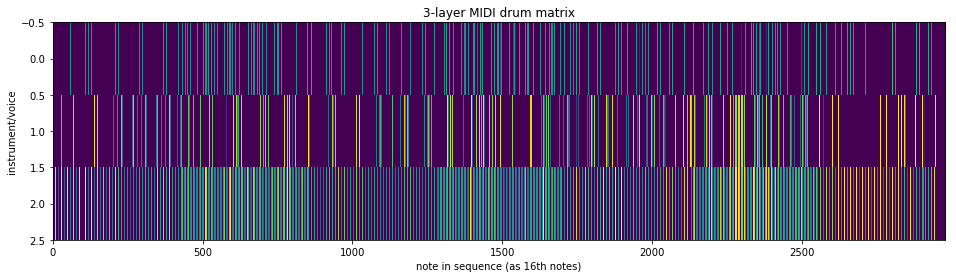

In [4]:
num_drums = 3       # kick, snare, hh
tatums_per_beat = 4 # 16th notes
period = 16
filename = '../data/Drum_n_bass.mid'

# use Battenberg's helper functions to get the drum matrix and beat number (in 16th notes)
drum_matrix, tempo = midi_tools.midi_to_drum_matrix(filename, tatums_per_beat=tatums_per_beat) 
beat_num = midi_tools.label_drum_matrix(drum_matrix.shape[1],period=period)
drum_matrix = drum_matrix[:num_drums]
#drum_matrix = drum_matrix[:num_drums].T

# midi_to_drum_matrix function returns velocity in range [0.0, 1.0], so let's get it in MIDI values
drum_matrix = np.int16(drum_matrix*127)    
print drum_matrix.shape

# plot 
plt.figure(figsize=(16,4))
plt.imshow(drum_matrix, aspect='auto', interpolation='none')
plt.xlabel('note in sequence (as 16th notes)')
plt.ylabel('instrument/voice')
plt.title('3-layer MIDI drum matrix')

# Questions:
# which layer is which instrument?

### Segment MIDI file into bar-length sequences (prepare data for training)

cutting off incomplete bar at index: 2976


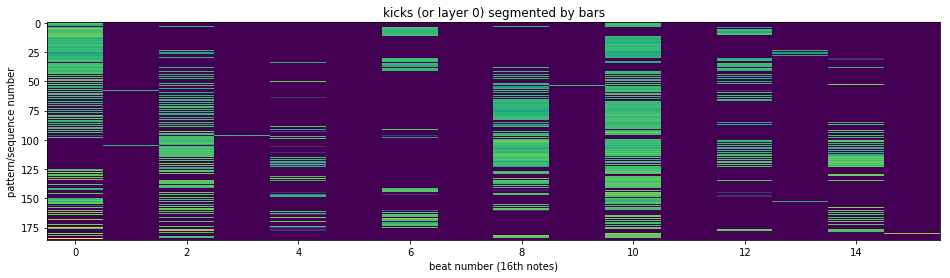

In [5]:
# let's just work with the kicks for now 
kicks = drum_matrix[0].astype(int)

# which are the voices??
snares = drum_matrix[1].astype(int)
hh = drum_matrix[2].astype(int)

# find the downbeat indices 
dbi = np.where(beat_num==1)[0]
n_bars = len(dbi)

# create a matrix to hold each separate piece of the training data
total_n_beats = len(kicks)
kicks_bar = np.zeros((len(dbi), period), dtype='int')
snares_bar = np.zeros((len(dbi), period), dtype='int')
hh_bar = np.zeros((len(dbi), period), dtype='int')
for i, el in enumerate(dbi):
    if el+period > total_n_beats:
        print "cutting off incomplete bar at index: " + str(el)
        kicks_bar = np.delete(kicks_bar, (n_bars-1), axis=0)
        snares_bar = np.delete(snares_bar, (n_bars-1), axis=0)
        hh_bar = np.delete(hh_bar, (n_bars-1), axis=0)
        n_bars = n_bars - 1
        break
    kicks_bar[i,:] = kicks[el:el+period]
    snares_bar[i,:] = snares[el:el+period]
    hh_bar[i,:] = hh[el:el+period]

# plot the bar-length sequences
plt.figure(figsize=(16,4))
plt.imshow(kicks_bar, aspect='auto', interpolation='none')
#plt.imshow(snares_bar, aspect='auto', interpolation='none')
#plt.imshow(hh_bar, aspect='auto', interpolation='none')
plt.xlabel('beat number (16th notes)')
plt.ylabel('pattern/sequence number')
plt.title('kicks (or layer 0) segmented by bars')

### MIDI segments to bit representation

In [6]:
def dec2Bit(d, n_bits):
    
    # get the bit representation as a string
    s = str(bin(d))[2:]
        
    # tack on zeros to the left if we have less bits than n_bits
    if len(s) < n_bits:
        s = '0' * (n_bits-len(s)) + s
            
    # get the strings as integers
    bits = [int(j) for j in s]
        
    return bits

def bit2Dec(bits, n_bits):

    twos = 2*np.ones((1,n_bits))
    powers = np.arange(n_bits-1, -1, step=-1)
    twoPowers = np.power(twos, powers)

    dec = np.sum(bits * twoPowers)
    
    return dec

In [7]:
# dec2Bit in C style
n_bits = 7
d = 13
bits = np.zeros((n_bits,))
i = 0
    
while(d != 0):
    remainder = d%2
    d = d/2
    bits[n_bits-i-1] = remainder
    i = i+1

print bits

[ 0.  0.  0.  1.  1.  0.  1.]


In [8]:
# bit2Dec in C style
dec = 0;
for i in range(n_bits):
    dec = dec + (bits[i] * 2**(n_bits-i-1));
print dec;

13.0


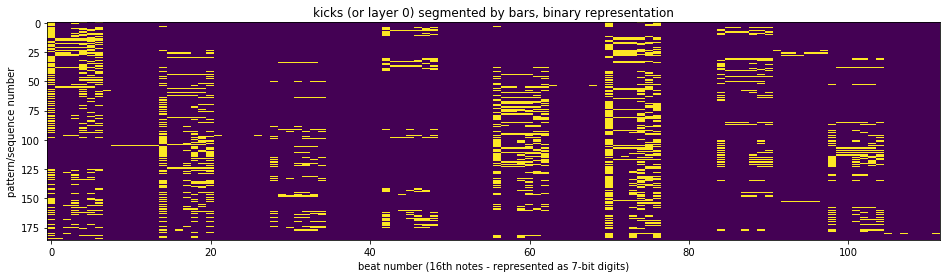

In [9]:
n_bits = 7

kicks_bb = np.zeros((n_bars, n_bits*period), dtype='int')
snares_bb = np.zeros((n_bars, n_bits*period), dtype='int')
hh_bb = np.zeros((n_bars, n_bits*period), dtype='int')

for b in range(0, n_bars):
    
    seqK = kicks_bar[b,:]
    seqS = snares_bar[b,:]
    seqH =hh_bar[b,:]
    
    for i in range(0, period):
    
        bitsK = dec2Bit(seqK[i], n_bits)
        kicks_bb[b, i*n_bits:(i+1)*n_bits] = bitsK
        
        bitsS = dec2Bit(seqS[i], n_bits)
        snares_bb[b, i*n_bits:(i+1)*n_bits] = bitsS
        
        bitsH = dec2Bit(seqH[i], n_bits)
        hh_bb[b, i*n_bits:(i+1)*n_bits] = bitsH

# plot the bar-length sequences in binary
plt.figure(figsize=(16,4))
plt.imshow(kicks_bb, aspect='auto', interpolation='none')
#plt.imshow(snares_bb, aspect='auto', interpolation='none')
#plt.imshow(hh_bb, aspect='auto', interpolation='none')
plt.xlabel('beat number (16th notes - represented as 7-bit digits)')
plt.ylabel('pattern/sequence number')
plt.title('kicks (or layer 0) segmented by bars, binary representation')

 ### Use the binary representation as input to an RBM

In [10]:
# train the RBM (WITH ONE VOICE)
n_visible = n_bits * period
n_hidden = 100 # 100 units is much better than 16 hidden units!
r = RBM(num_visible=n_visible, num_hidden=n_hidden)
r.train(kicks_bb, max_epochs = 90000, print_units = 10000)

Epoch 0: error is 5598.38233688
Epoch 10000: error is 10.0042604413
Epoch 20000: error is 5.6863730904
Epoch 30000: error is 2.48962850329
Epoch 40000: error is 1.91225301194
Epoch 50000: error is 2.14623177602
Epoch 60000: error is 1.81861581126
Epoch 70000: error is 0.116722665561
Epoch 80000: error is 1.68295928847


In [11]:
print "size of input data: " + str(kicks_bb.shape)
print "weights shape: " + str(r.weights.shape)
print "and the weights themselves: " + str(r.weights)

# we have 112 visible nodes and a bias (113 rows); 16 hidden units and 1 bias unit (17 columns)

size of input data: (186, 112)
weights shape: (113, 101)
and the weights themselves: [[ 5.49412492  3.81381691  2.97817012 ...,  0.03231429  0.09502659
   1.10206346]
 [ 1.54586306 -3.66458288  2.66618144 ...,  0.46365996  0.5861095
  -3.23024095]
 [ 0.08459747 -0.18420064 -1.71942576 ..., -0.20703785 -1.43544779
   0.82887526]
 ..., 
 [-0.2068219  -0.27765319 -0.17126949 ..., -0.22600923 -0.34386225
  -0.54421925]
 [-0.19025306 -0.27381064 -0.29916969 ..., -0.51359115 -0.21540683
  -0.30511046]
 [-0.57365057 -0.61335387 -1.0560019  ..., -0.81018115 -0.74808398
  -0.83017246]]


In [12]:
# train the RBM (WITH MULTIPLE VOICES)

# concatenate the 3 voices
n_voices = 3
X = np.hstack((kicks_bb, snares_bb, hh_bb))
n_visible = n_bits * period * n_voices
n_hidden = 700
r = RBM(num_visible=n_visible, num_hidden=n_hidden)
r.train(X, max_epochs = 10000, print_units = 1000)

#n_visible = n_bits * period
#n_hidden = 100 # 100 units is much better than 16 hidden units!
#r = RBM(num_visible=n_visible, num_hidden=n_hidden)
#r.train(kicks_bb, max_epochs = 90000)

Epoch 0: error is 19611.5615623
Epoch 1000: error is 225.096452859
Epoch 2000: error is 99.8890643479
Epoch 3000: error is 62.1205002637
Epoch 4000: error is 35.6027969222
Epoch 5000: error is 23.2035429977
Epoch 6000: error is 16.5461091961
Epoch 7000: error is 17.3533713715
Epoch 8000: error is 13.0203149023
Epoch 9000: error is 9.25630408772


In [13]:
print "size of input data: " + str(kicks_bb.shape)
print "weights shape: " + str(r.weights.shape)
print "and the weights themselves: " + str(r.weights)
np.savetxt('weights.txt', r.weights, delimiter='\n')  

size of input data: (186, 112)
weights shape: (337, 701)
and the weights themselves: [[ 2.14559977 -0.89269063 -0.10206579 ...,  0.6052253   0.90851401
   0.68152647]
 [-0.0508974  -0.16035674  0.37683089 ..., -0.13042892  0.11559317
   0.03917723]
 [ 0.37769275 -0.30604067  0.18117395 ...,  0.27979414  0.3460567
  -0.10998527]
 ..., 
 [-0.04205333 -0.03807003 -0.09889957 ..., -0.19156455 -0.0882031
  -0.02201562]
 [-0.02164085 -0.05837443 -0.17995479 ..., -0.06826455  0.06553698
  -0.10366631]
 [-0.0242626   0.07079354  0.0265149  ..., -0.04351595  0.09030006
  -0.09100871]]


In [14]:
i = 0
for v in range(4):
    for h in range(3):
        i = i + 1
print i

for i in range(12):
    print (i/4, np.mod(i, 4))
    
print 337*701

12
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
236237


### run_visible() and run_hidden() routines (C-style)

In [96]:
def run_visible(data, weights):
    
    n_examples = data.shape[0]
    n_visible = data.shape[1]
    n_hidden = weights.shape[1]-1
    w = weights
    
    # add bias unit to the data
    dataNew = np.zeros((n_examples, n_visible+1))
    for ex in range(n_examples):
        for v in range(n_visible+1):
            if v==0:
                dataNew[ex,v] = 1.0
            else:
                dataNew[ex,v] = data[ex,v-1]
                
    # initialize hidden states and bias to 1
    hiddenStates = np.zeros((n_examples, n_hidden+1))
    for ex in range(n_examples):
        for h in range(n_hidden+1):
            hiddenStates[ex,h] = 1.0
    
    # calculate activations of hidden units
    hiddenActivations = np.zeros((n_examples, n_hidden+1))
    for ex in range(n_examples):
        for h in range(n_hidden+1):
            rowSum = 0
            for v in range(n_visible+1):
                rowSum = rowSum + (dataNew[ex,v]*w[v, h])
            hiddenActivations[ex, h] = rowSum
    
    # calculate probabilities of turning hidden units on (with logistic function)
    hiddenProbs = np.zeros((n_examples, n_hidden+1))

    for ex in range(n_examples):
        for h in range(n_hidden+1):
            hiddenProbs[ex, h] = 1.0 / (1.0 + np.exp(-hiddenActivations[ex,h]))
    
    # turn hidden units on according to the hidden node probabilities and flipping a coin
    for ex in range(n_examples):
        for h in range(n_hidden+1):
            if hiddenProbs[ex, h] > np.random.rand(1):
                hiddenStates[ex, h] = 1.0
            else:
                hiddenStates[ex, h] = 0.0

    # return hidden states without the bias
    return hiddenStates[:, 1:]

In [108]:
def run_hidden(data, weights):
    
    n_examples = data.shape[0]
    n_hidden = data.shape[1]
    n_visible = weights.shape[0]-1
    w = weights
    
    # add bias unit to the data
    dataNew = np.zeros((n_examples, n_hidden+1))
    for ex in range(n_examples):
        for h in range(n_hidden+1):
            if h==0:
                dataNew[ex,h] = 1.0
            else:
                dataNew[ex,h] = data[ex,h-1]
                
    # initialize visible states and bias to 1
    visibleStates = np.zeros((n_examples, n_visible+1))
    for ex in range(n_examples):
        for v in range(n_visible+1):
            visibleStates[ex,v] = 1.0
            
    # calculate activations of visible units
    visibleActivations = np.zeros((n_examples, n_visible+1))
    for ex in range(n_examples):
        for v in range(n_visible+1):
            rowSum = 0
            for h in range(n_hidden+1):
                rowSum = rowSum + (dataNew[ex,h]*w[v, h])
            visibleActivations[ex, v] = rowSum
            
    # calculate probabilities of turning visible units on (with logistic function)
    visibleProbs = np.zeros((n_examples, n_visible+1))
    for ex in range(n_examples):
        for v in range(n_visible+1):
            visibleProbs[ex, v] = 1.0 / (1.0 + np.exp(-visibleActivations[ex,v]))
    
    # turn visible units on according to the visible node probabilities and flipping a coin
    for ex in range(n_examples):
        for v in range(n_visible+1):
            if visibleProbs[ex, v] > np.random.rand(1):
                visibleStates[ex, v] = 1.0
            else:
                visibleStates[ex, v] = 0.0

    # return visible states without the bias
    return visibleStates[:, 1:]

### Use another beat as the "seed" beat

In [83]:
# ONE VOICE
# I'm going to make my own beat up
seed_beat = np.array([120, 0, 0, 0, 0, 0, 110, 0, 0, 0, 0, 0, 115, 0, 0, 0])
seed_bb = np.zeros((1, n_bits*period))
for i in range(0, period):
        bits = dec2Bit(seed_beat[i], n_bits)
        seed_bb[0, i*n_bits:(i+1)*n_bits] = bits
print seed_bb

[[ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  1.  1.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  1.
   1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]]


In [15]:
# make reconstructions
h = r.run_visible(seed_bb)
rec = r.run_hidden(h)
print rec

[[ 1.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]]


In [124]:
# go from binary representation to decimal/MIDI velocity
dec_bar = np.zeros((1, period), dtype='int')

# segment into each decimal digit
for i in range(period):

    bits = rec[0, i*n_bits:(i+1)*n_bits]
    dec = bit2Dec(bits, n_bits)
    dec_bar[0, i] = dec
    
print dec_bar

[[102   0   0   0   0   0 106   0   0  16   0   0 114   0   0   0]]


In [12]:
# MULTIPLE VOICES
# I'm going to make my own beat up
seed_beat = np.array([120, 0, 0, 0, 0, 0, 118, 0, 0, 0, 0, 0, 115, 0, 0, 0,
                      0, 0, 0, 0, 125, 0, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0,
                      0, 0, 0, 100, 110, 100, 0, 0, 0, 0, 0, 0, 110, 0, 105, 0,
                     ])
seed_bb = np.zeros((1, n_bits*len(seed_beat)))
for i in range(0, len(seed_beat)):
        bits = dec2Bit(seed_beat[i], n_bits)
        seed_bb[0, i*n_bits:(i+1)*n_bits] = bits
print seed_bb

[[ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  1.
   1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
   1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
   1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0. 

In [17]:
# make reconstructions
h = r.run_visible(seed_bb)
rec = r.run_hidden(h)
print rec

[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.
   1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
   1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  1.  0.  0.  0. 

In [18]:
# go from binary representation to decimal/MIDI velocity
recKicks = np.zeros((1, period), dtype='int')
recSnares = np.zeros((1, period), dtype='int')
recHh = np.zeros((1, period), dtype='int')

# segment into each decimal digit
for i in range(period):

    bits = rec[0, i*n_bits:(i+1)*n_bits]
    dec = bit2Dec(bits, n_bits)
    recKicks[0, i] = dec
    
    bits = rec[0, 112+(i*n_bits):112+((i+1)*n_bits)]
    dec = bit2Dec(bits, n_bits)
    recSnares[0, i] = dec
    
    bits = rec[0, 224+(i*n_bits):224+((i+1)*n_bits)]
    dec = bit2Dec(bits, n_bits)
    recHh[0, i] = dec
    
print recKicks
print recSnares
print recHh

[[ 1  0  0  0  2  0 70  0  0  0  0  0  2  0  0  0]]
[[  0   0   0   0  93   0   0   0   0   0  32   0 120   0   0   0]]
[[112   0  32   0 110   0   1   0  64   0  64   0  78   0   9   0]]


### test my functions (results should be similar and change just a little bit)

In [111]:
# run_visible()
hs = run_visible(seed_bb, r.weights)
hs1 = r.run_visible(seed_bb)
print "run_visible():"
print "my code: \n" + str(hs)
print "echen code: \n" + str(hs1)
print "\n"

# run_hidden()
vs = run_hidden(hs, r.weights)
vs1 = r.run_hidden(hs)
print "run_hidden():"
print "my code: \n" + str(vs)
print "echen code: \n" + str(vs1)

run_visible():
my code: 
[[ 0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  1.  1.  0.  0.
   1.  0.  0.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.
   1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.  0.  1.  0.  1.
   1.  0.  0.  1.  1.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
   0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  1.  0.
   1.  1.  0.  0.  1.  0.  0.  0.  0.  1.]]
echen code: 
[[ 0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  1.  0.
   1.  0.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.
   1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.
   0.  0.  1.  1.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.
   0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  1.
   1.  1.  0.  1.  1.  0.  0.  1.  0.  0.]]


run_hidden():
my code: 
[[ 1.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0. 

### Conclusion

Ok, so all the pieces to train this and generate are in this notebook. 

For real training:
* write a Python script
* concatenate all 3 voices together and train a network with 500 (or so) hidden nodes
* print out or save the weights+biases to a file

For generation:
* write a Pd extern
* input: seed pattern in MIDI form for 3 voices (3 inlets?)
* output: generated pattern in MIDI form for 3 voices (3 outlets?)

At some point, I will want to experiment with:
* using real numbers instead of binary/bit versions of the MIDI velocities to reduce the number of hidden nodes
* OR use the bit version of MIDI velocities but only have it go through like 6 levels
* introduce clamping into the generation
* play around with the hidden nodes as a way of generation
